In [74]:
!pip install feature_engine

In [75]:
!pip install sweetviz

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.metrics import accuracy_score

import joblib
import pickle

In [77]:
df = pd.read_csv("/content/credit.csv")
df.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'employment_duration', 'percent_of_income',
       'years_at_residence', 'age', 'other_credit', 'housing',
       'existing_loans_count', 'job', 'dependents', 'phone', 'default'],
      dtype='object')

In [78]:
df.isnull().sum()

checking_balance        0
months_loan_duration    0
credit_history          0
purpose                 0
amount                  0
savings_balance         0
employment_duration     0
percent_of_income       0
years_at_residence      0
age                     3
other_credit            0
housing                 0
existing_loans_count    0
job                     0
dependents              0
phone                   0
default                 0
dtype: int64

In [79]:
import sweetviz as sv

                                             |          | [  0%]   00:00 -> (? left)


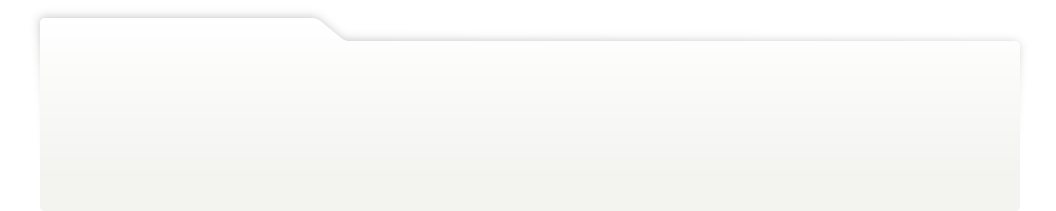
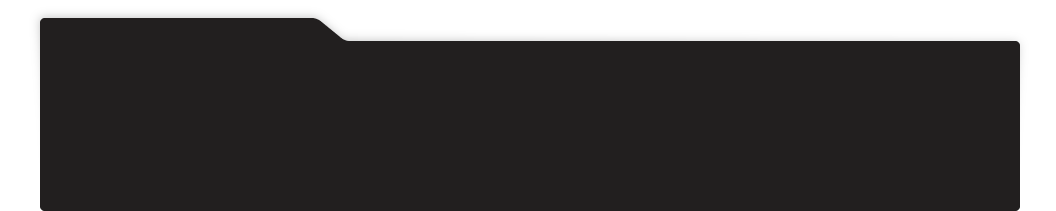
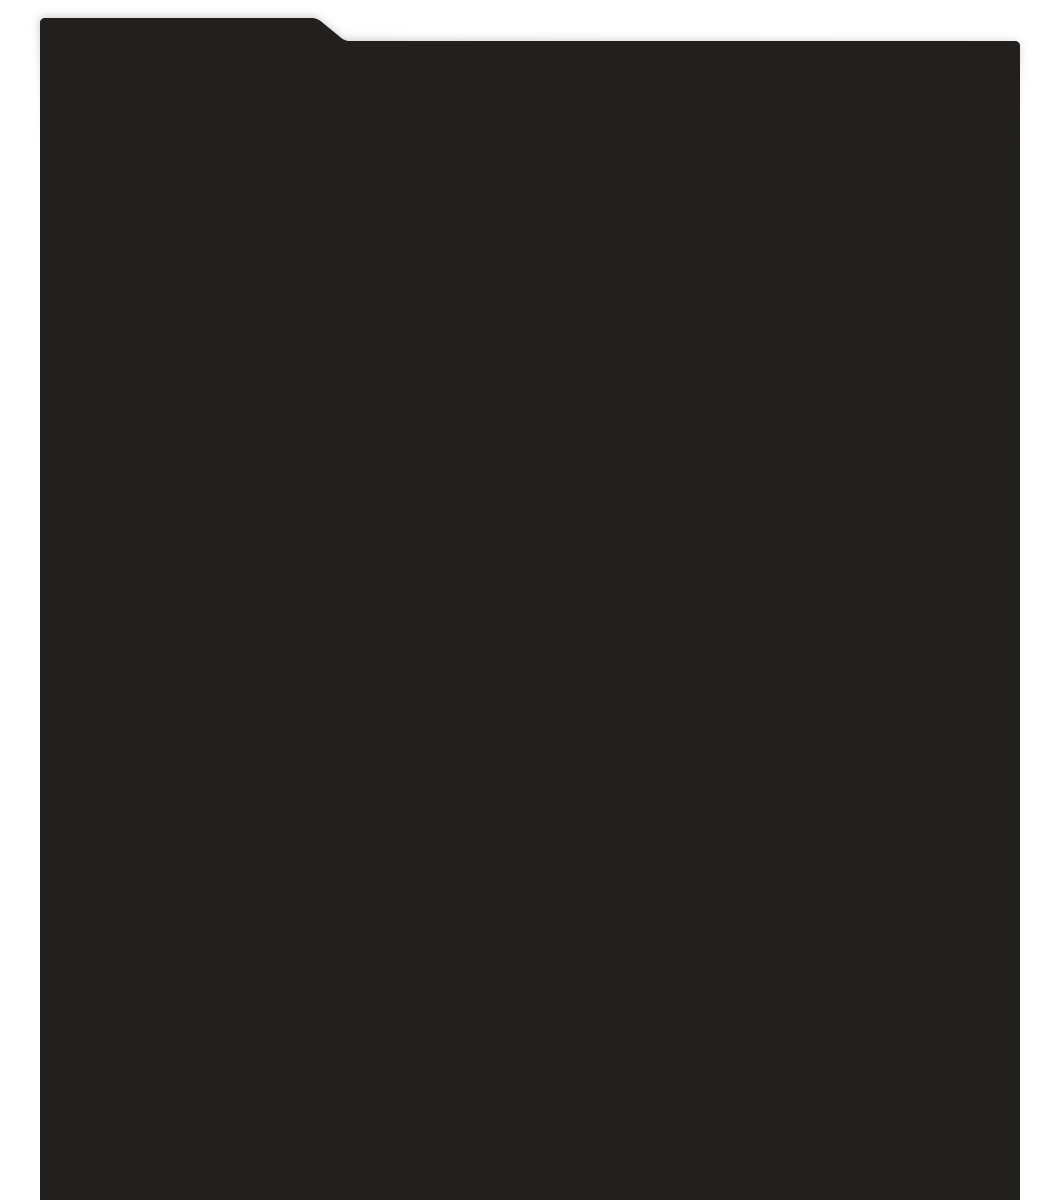
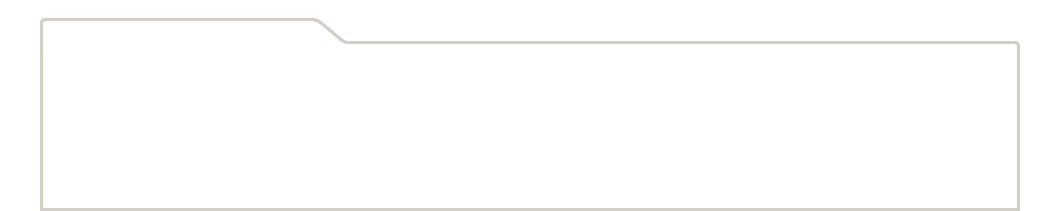
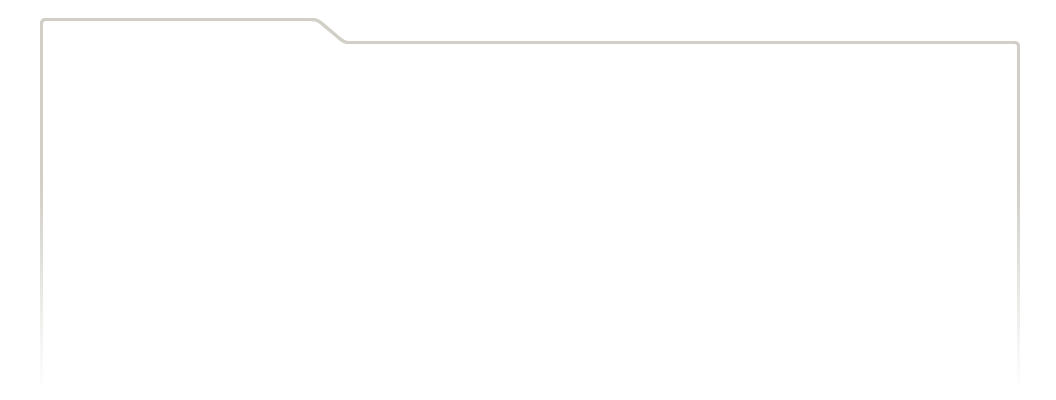
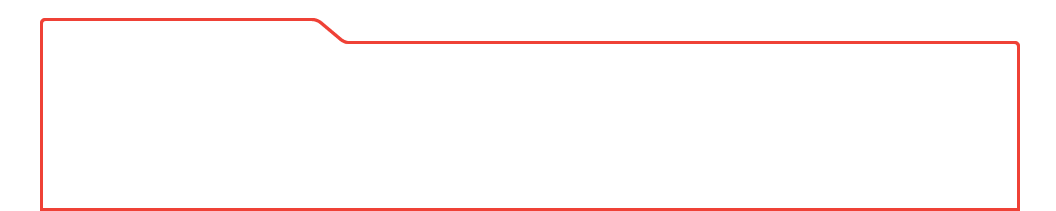
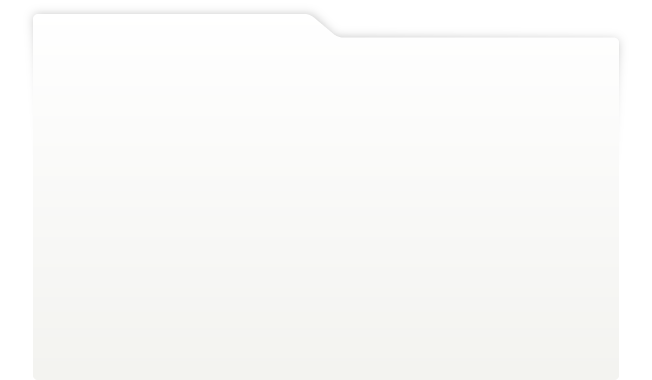
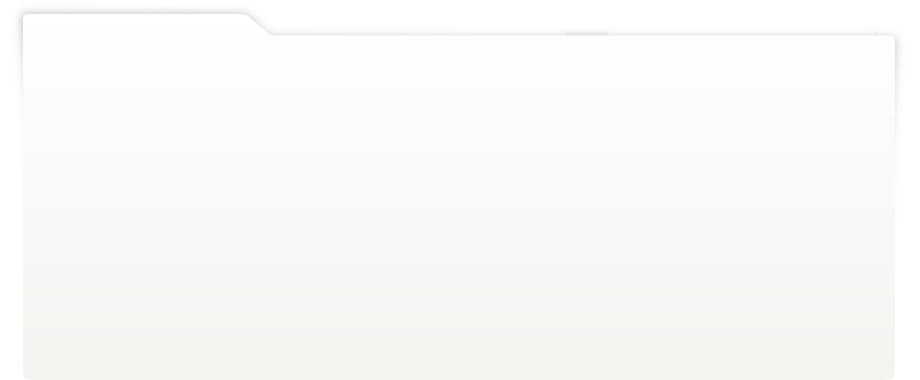
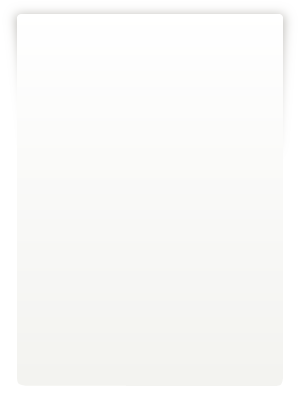
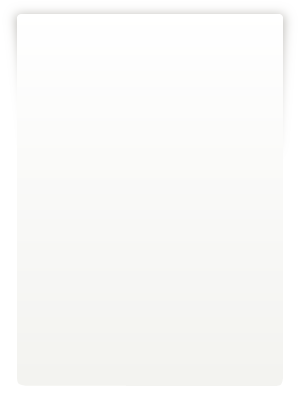
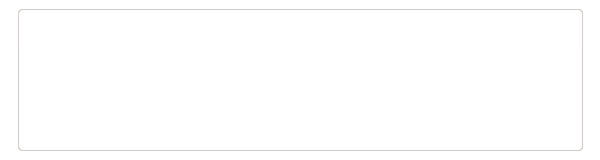
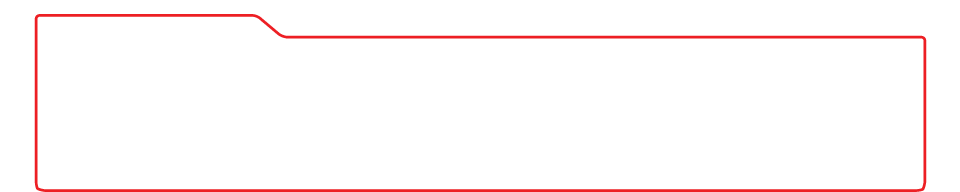
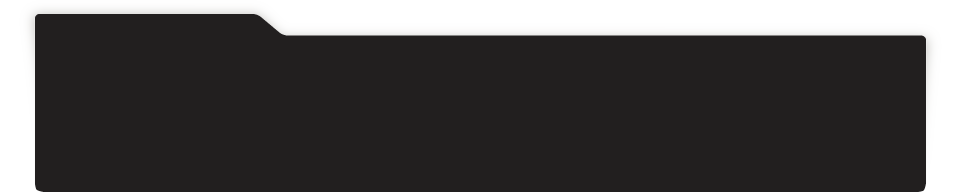
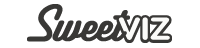
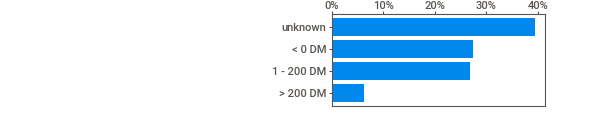
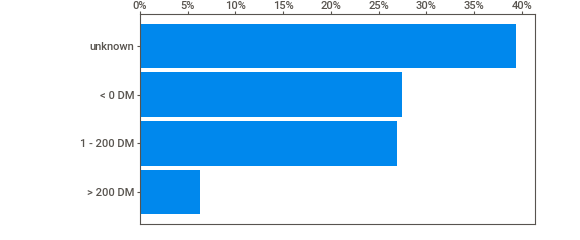
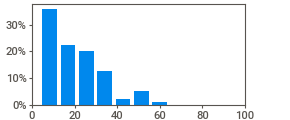
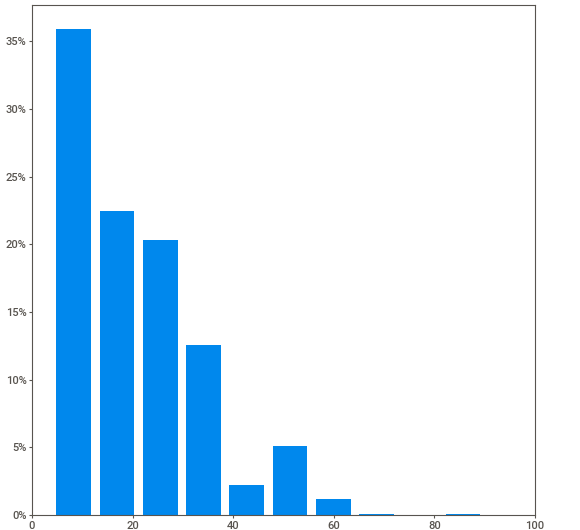
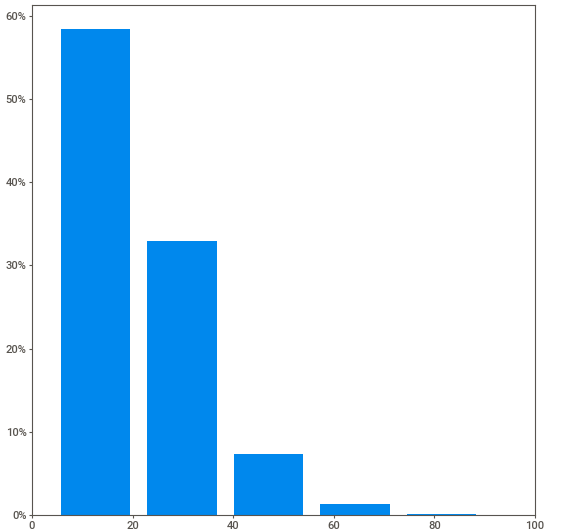
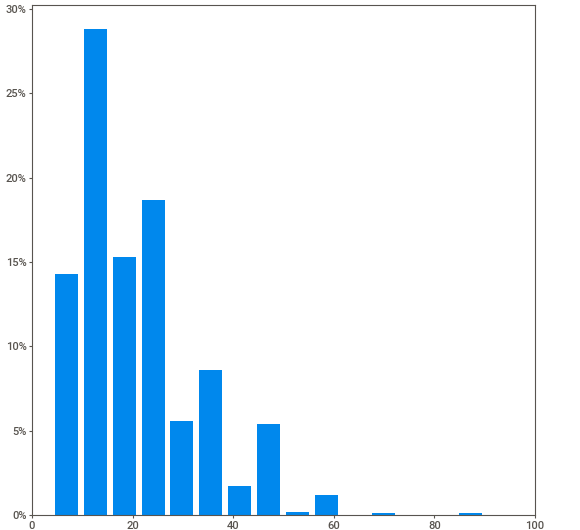
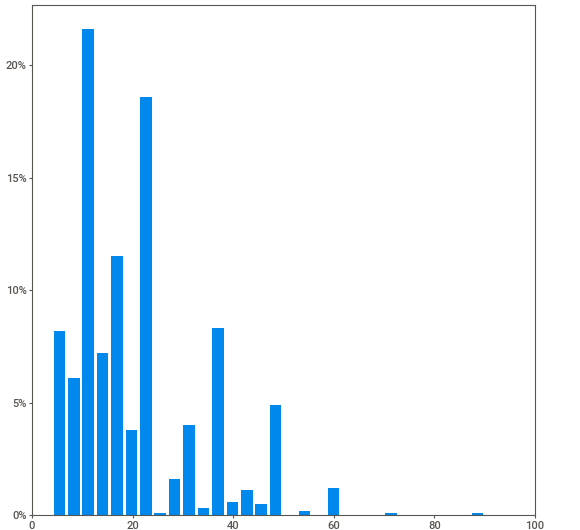
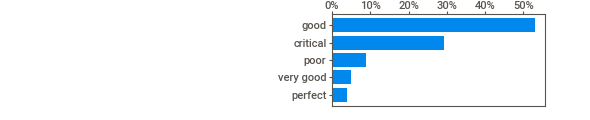
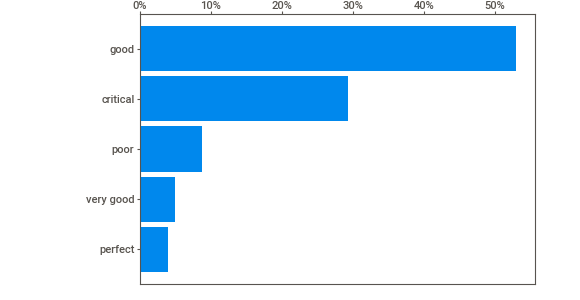
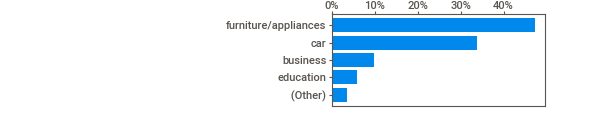
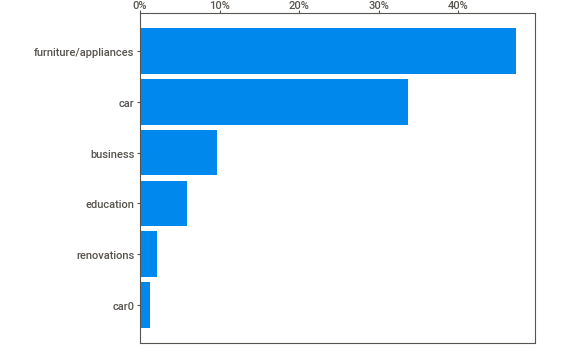
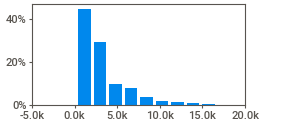
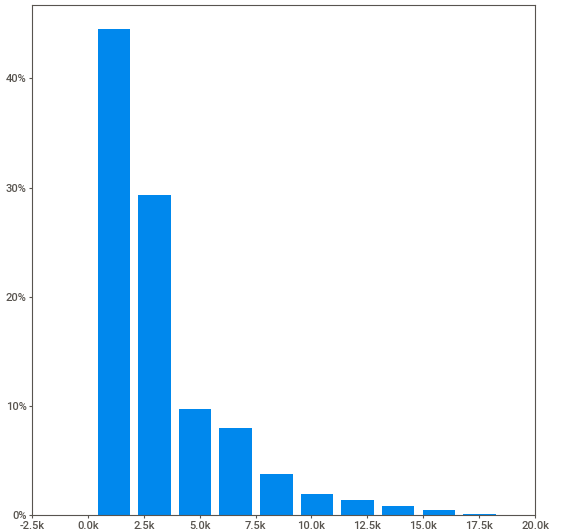
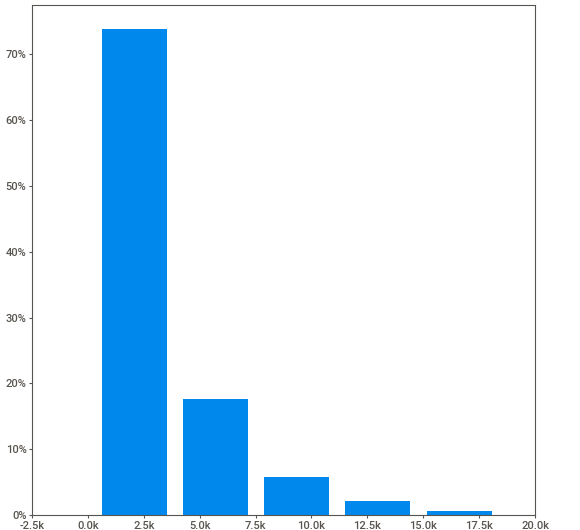
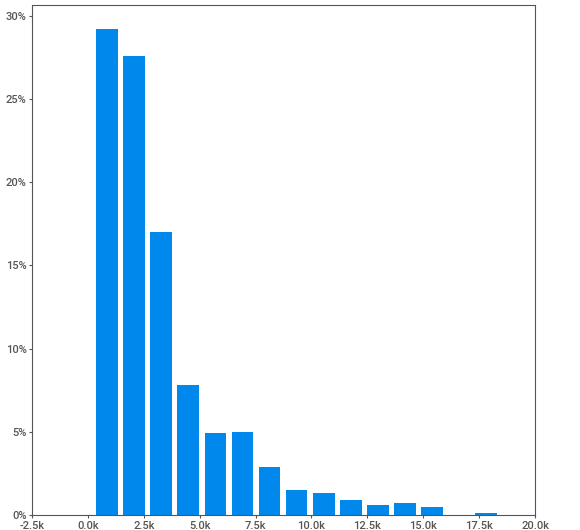
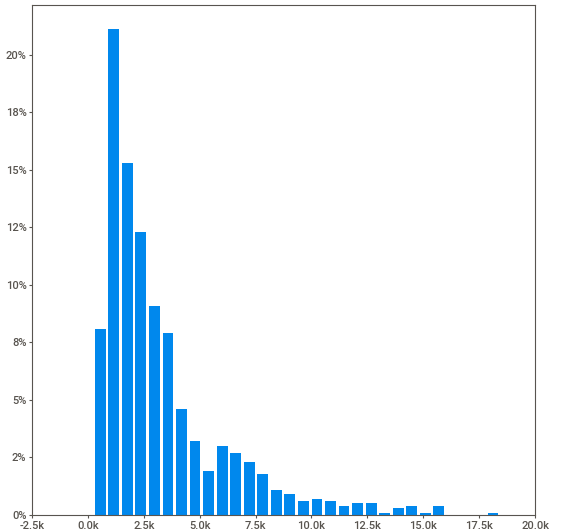
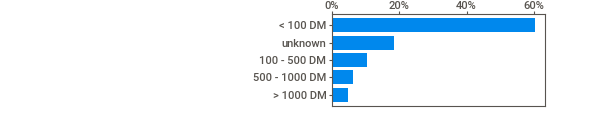
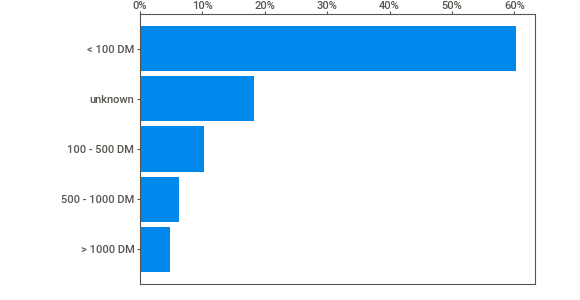
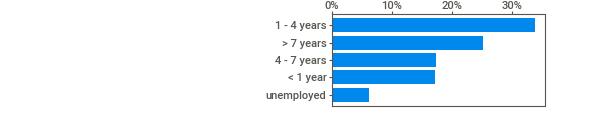
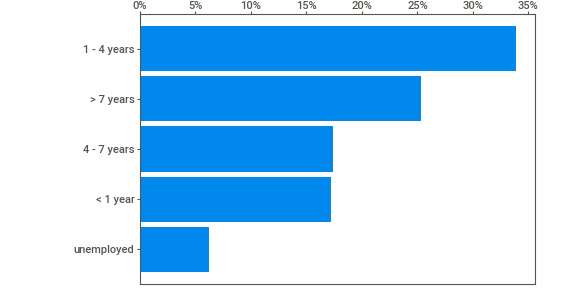
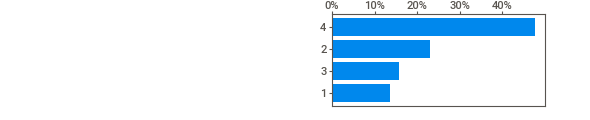
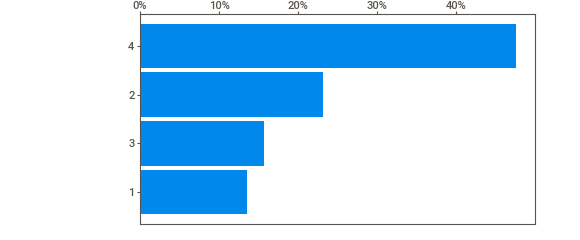
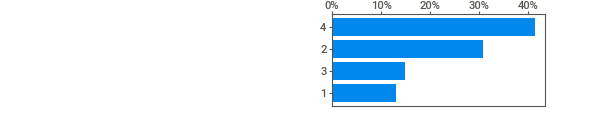
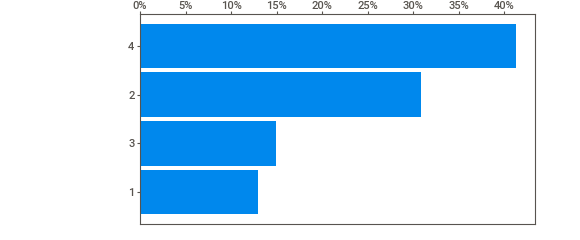
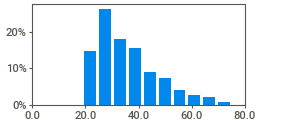
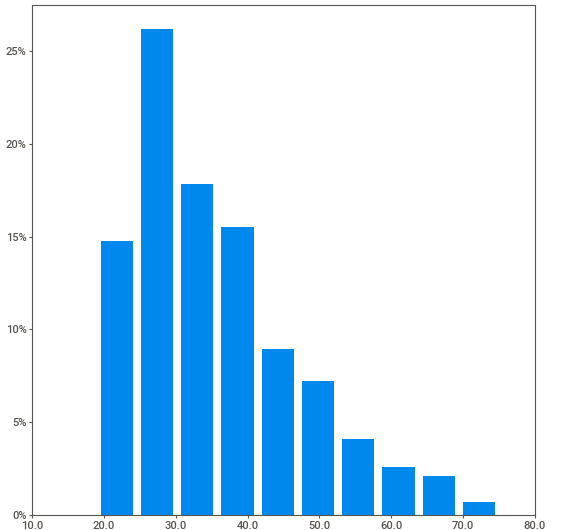
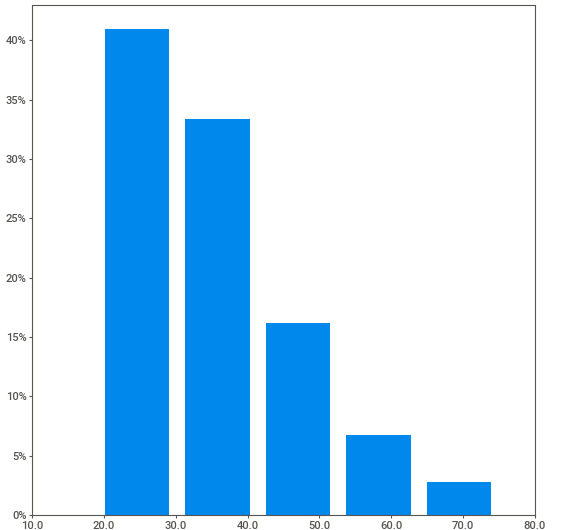
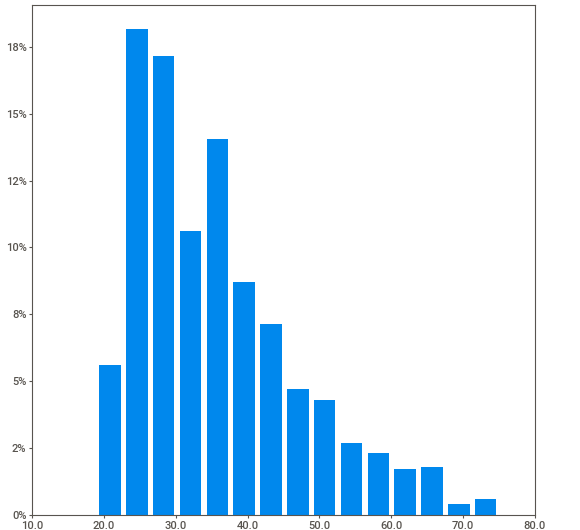
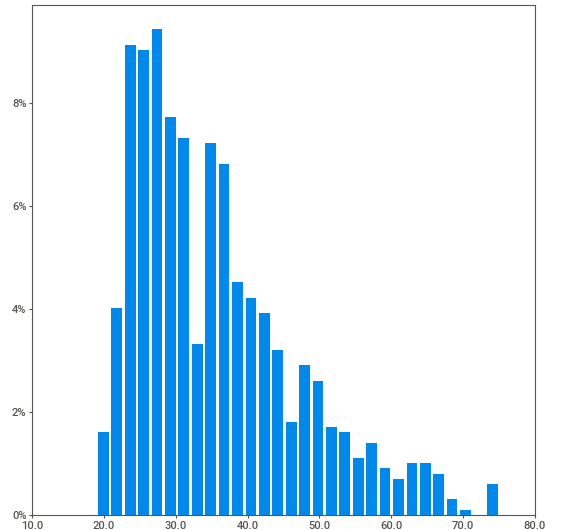
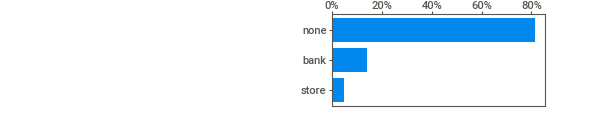
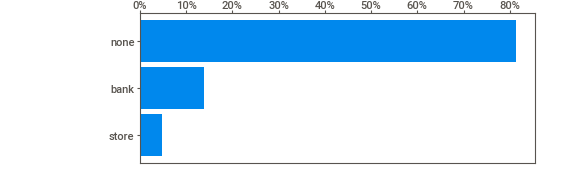
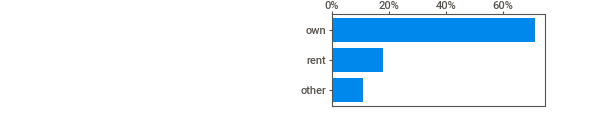
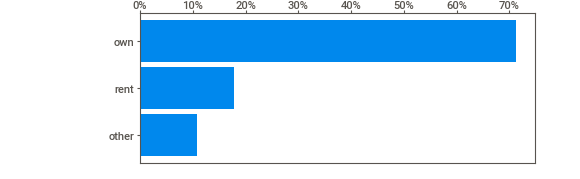
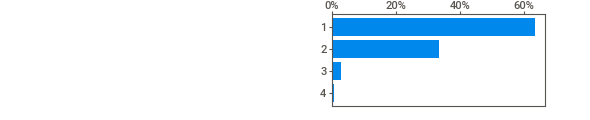
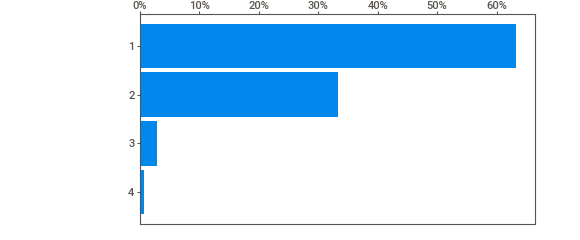
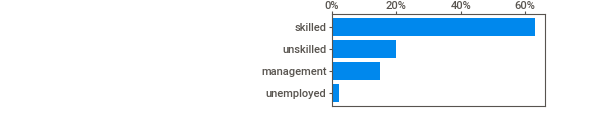
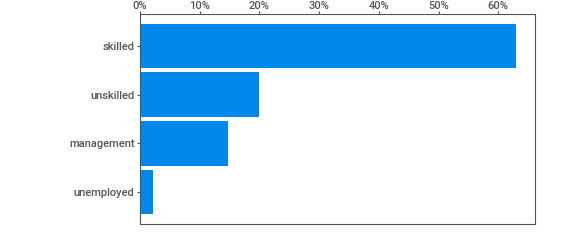
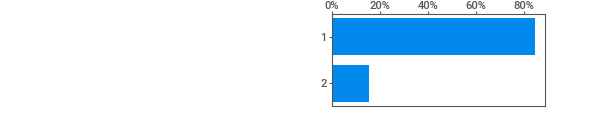
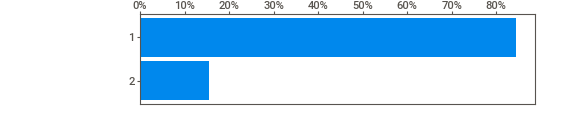
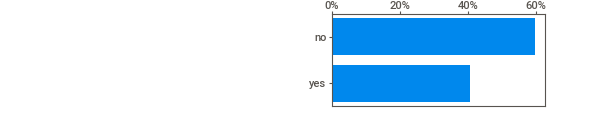
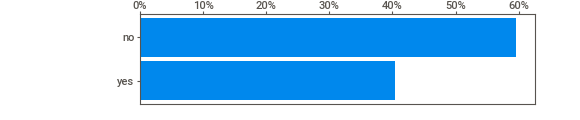
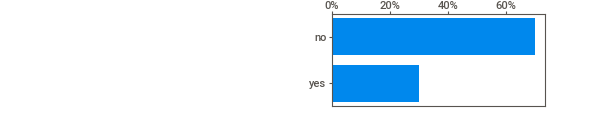
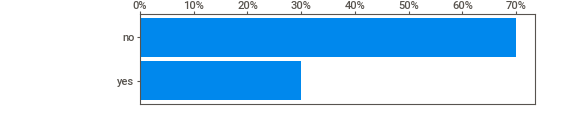
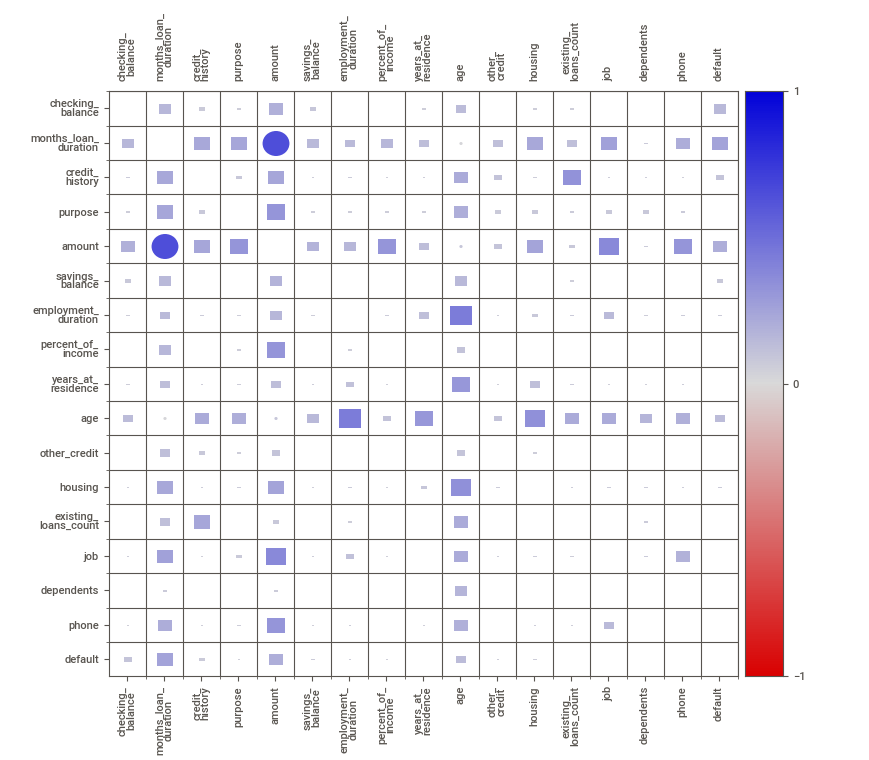
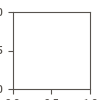

In [80]:
rep = sv.analyze(df)
rep.show_notebook('Report')

In [81]:
df=df.drop(['phone'],axis = 1)

In [82]:
df['default'].unique()
df['default'].value_counts()

no     700
yes    300
Name: default, dtype: int64

In [83]:
x = df.iloc[:, :15]
y = df['default'] #Target

In [84]:
num_feat = x.select_dtypes(exclude = ['object']).columns

In [85]:
cat_feat = x.select_dtypes(include = ['object']).columns

In [86]:
num_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy ='mean')),('scale',MinMaxScaler())])

In [87]:
encoding_pipeline = Pipeline([('onehot', OneHotEncoder(drop = 'first'))])

In [88]:
preprocessor = ColumnTransformer(transformers = [('num', num_pipeline , num_feat), ('cat' , encoding_pipeline, cat_feat)])

In [89]:
imp_enc_scale = preprocessor.fit(x)

In [90]:
joblib.dump(imp_enc_scale , 'Imp-Enc-Scaling')

['Imp-Enc-Scaling']

In [91]:
clean_df = pd.DataFrame(imp_enc_scale.transform(x), columns = imp_enc_scale.get_feature_names_out())

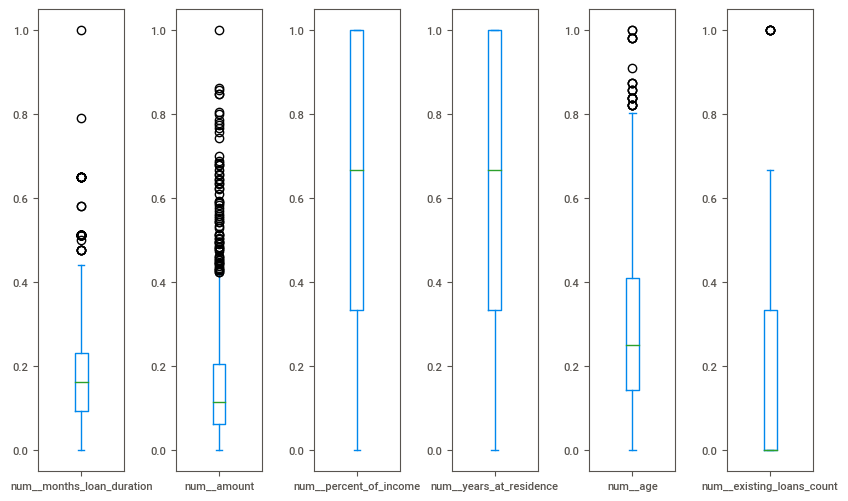

In [92]:
clean_df.iloc[:, 0:6].plot(kind = 'box', subplots = True, sharey = False, figsize =(10,6))
plt.subplots_adjust(wspace =0.6)
plt.show()

In [93]:
clean_df.columns

Index(['num__months_loan_duration', 'num__amount', 'num__percent_of_income',
       'num__years_at_residence', 'num__age', 'num__existing_loans_count',
       'num__dependents', 'cat__checking_balance_< 0 DM',
       'cat__checking_balance_> 200 DM', 'cat__checking_balance_unknown',
       'cat__credit_history_good', 'cat__credit_history_perfect',
       'cat__credit_history_poor', 'cat__credit_history_very good',
       'cat__purpose_car', 'cat__purpose_car0', 'cat__purpose_education',
       'cat__purpose_furniture/appliances', 'cat__purpose_renovations',
       'cat__savings_balance_500 - 1000 DM', 'cat__savings_balance_< 100 DM',
       'cat__savings_balance_> 1000 DM', 'cat__savings_balance_unknown',
       'cat__employment_duration_4 - 7 years',
       'cat__employment_duration_< 1 year',
       'cat__employment_duration_> 7 years',
       'cat__employment_duration_unemployed', 'cat__other_credit_none',
       'cat__other_credit_store', 'cat__housing_own', 'cat__housing_rent',
  

In [94]:
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables =['num__months_loan_duration', 'num__amount', 'num__percent_of_income',
       'num__years_at_residence', 'num__age', 'num__existing_loans_count'])
outlier = winsor.fit(clean_df[['num__months_loan_duration', 'num__amount', 'num__percent_of_income',
       'num__years_at_residence', 'num__age', 'num__existing_loans_count']])

In [95]:
joblib.dump(outlier, 'winsor')

['winsor']

In [96]:
clean_df[['num__months_loan_duration', 'num__amount', 'num__percent_of_income',
       'num__years_at_residence', 'num__age', 'num__existing_loans_count']] =outlier.transform(clean_df[['num__months_loan_duration', 'num__amount', 'num__percent_of_income',
       'num__years_at_residence', 'num__age', 'num__existing_loans_count']])

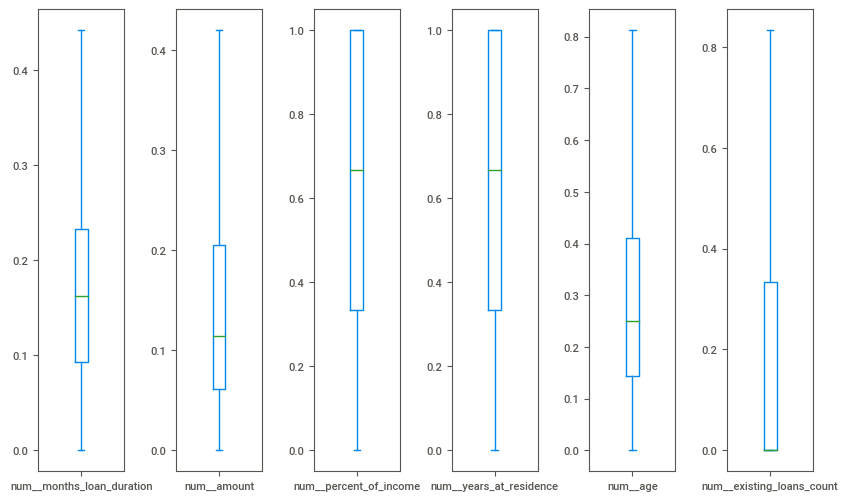

In [97]:
clean_df.iloc[:, 0:6].plot(kind = 'box', subplots = True, sharey = False, figsize =(10,6))
plt.subplots_adjust(wspace =0.6)
plt.show()

In [98]:
x_train, x_test, y_train, y_test = train_test_split(clean_df, y, test_size =0.2, stratify = y, random_state =0)

In [99]:
print(y_train.value_counts()/800)
print('/n')
print(y_test.value_counts()/200)

no     0.7
yes    0.3
Name: default, dtype: float64
/n
no     0.7
yes    0.3
Name: default, dtype: float64


In [100]:
model = DT(criterion = 'entropy')
model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [101]:
preds = model.predict(x_test)

In [102]:
print(accuracy_score(y_test, preds))

0.705


In [103]:
pd.crosstab(y_test, preds, rownames= ['Acutal'], colnames =['Predictions'])

Predictions,no,yes
Acutal,,
no,113,27
yes,32,28


In [104]:
from sklearn.model_selection import GridSearchCV

In [105]:
param_grid ={'criterion' :['gini','entropy'], 'max_depth' :np.arange(3,15)}
dtree = DT()
dtree_gsv = GridSearchCV(dtree, param_grid , scoring ='accuracy' ,return_train_score = False, verbose = 1)

In [106]:
dtree_gsv.fit(clean_df,y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring='accuracy', verbose=1)

In [109]:
dt_best = dtree_gsv.best_estimator_

DecisionTreeClassifier(max_depth=3)

In [110]:
preds1 = dt_best.predict(x_test)

In [111]:
print(accuracy_score(y_test, preds))

0.705


In [112]:
!pip install graphviz

In [116]:
from sklearn import tree
import graphviz
from sklearn.tree import export_graphviz

In [114]:
predictors = list(clean_df.columns)

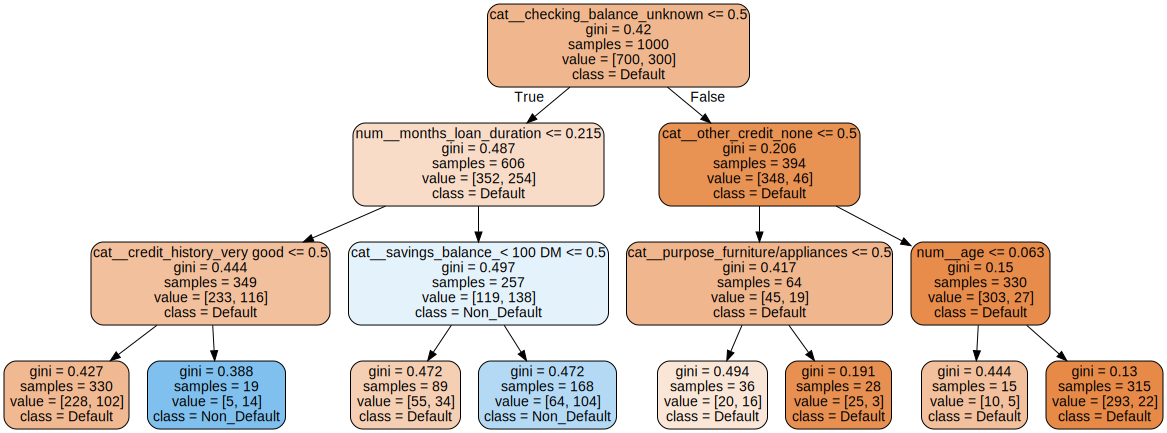

In [118]:
dot_data = tree.export_graphviz(dt_best, filled = True, rounded = True, feature_names = predictors, class_names =['Default', 'Non_Default'] , out_file = None)
graph = graphviz.Source(dot_data)

In [119]:
preds_train = dt_best.predict(x_train)
print(accuracy_score(y_train,preds_train))

0.745
